In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# A Simple Starter Code for the AJL Competition

@Cindy Deng

---


Hi! This starter code is designed to help you get familiar with basic Kaggle operations and guide you through the basic workflow of a machine learning project.

The code outlines essential steps including data loading, preprocessing, model building, training, and generating predictions. Each section serves as a foundation, but there are many ways to enhance each step to improve your final model's accuracy. Feel free to experiment with different data augmentation techniques, model architectures, and tuning methods to optimize your final results! Some amazing tutorials are available through your AI Studio course in Canvas / in the 'Resource' section of this Kaggle competition.

Good luck and have fun!

---

## Note - About file path

You could use the cell above to print the names of the file directories and get the following directories:

```
/kaggle/input/bttai-ajl-2025/sample_submission.csv
/kaggle/input/bttai-ajl-2025/train.csv
/kaggle/input/bttai-ajl-2025/test.csv
/kaggle/input/bttai-ajl-2025/test/test/e0374ae6c1362ff183cfba28ded5421b.jpg
/kaggle/input/bttai-ajl-2025/test/test/437159c605260bdd079af230566af291.jpg
...
...
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/11271bdf2598afdd4260db3125e1f6a5.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/732819951dcf2b53d15ea7b8bb123b71.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/6dcc7a8abb5e1c6e670101f4b6231246.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/e63c3b3f0ab8905e204fe467cc7411f9.jpg
...
...
```



## 1. Import Necessary Libraries

In [2]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample

# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

In [3]:
pip install tensorflow keras-efficientnet

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')  # Enables faster float16 computation


## 2. Load Data

Make sure to verify the file paths if you're running on a different platform.

In [5]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Define dataset path and make sure it exists
folder_path = "/content/drive/My Drive/Team Vitamin C (BTT)/bttai-ajl-2025"
os.listdir(folder_path)

['sample_submission.csv',
 'test.csv',
 'train.csv',
 'test',
 'train',
 'updated_train.gsheet',
 'updated_train.csv']

In [7]:
# Loop through each subdirectory and count number of images
train_images_path = folder_path + "/train/train"

# Loop through each subdirectory in training images
for condition in os.listdir(train_images_path):
    condition_path = os.path.join(train_images_path, condition)

    # Make sure it is a directory
    if os.path.isdir(condition_path):
        num_images = len([f for f in os.listdir(condition_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{condition}: {num_images} images")

seborrheic-keratosis: 624 images
prurigo-nodularis: 119 images
superficial-spreading-melanoma-ssm: 332 images
mycosis-fungoides: 127 images
melanoma: 181 images
squamous-cell-carcinoma: 407 images
pyogenic-granuloma: 316 images
keloid: 109 images
kaposi-sarcoma: 109 images
malignant-melanoma: 312 images
dermatofibroma: 220 images
folliculitis: 239 images
eczema: 143 images
epidermal-nevus: 256 images
basal-cell-carcinoma-morpheiform: 172 images
dermatomyositis: 106 images
dyshidrotic-eczema: 232 images
actinic-keratosis: 122 images
acne-vulgaris: 234 images
basal-cell-carcinoma: 328 images
acne: 128 images


In [8]:
# 2. Load Data
train_df = pd.read_csv(folder_path + "/updated_train.csv")
test_df = pd.read_csv(folder_path + "/test.csv")
# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

In [9]:
# Check the first few rows to understand the structure
train_df.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,ddi_scale,file_path
0,fd06d13de341cc75ad679916c5d7e6a6.jpg,4,4,prurigo-nodularis,benign-epidermal,benign,NaN,34,prurigo-nodularis/fd06d13de341cc75ad679916c5d7...
1,a4bb4e5206c4e89a303f470576fc5253.jpg,1,1,basal-cell-carcinoma-morpheiform,malignant-epidermal,malignant,NaN,12,basal-cell-carcinoma-morpheiform/a4bb4e5206c4e...
2,c94ce27e389f96bda998e7c3fa5c4a2e.jpg,5,5,keloid,inflammatory,non-neoplastic,1 Diagnostic,56,keloid/c94ce27e389f96bda998e7c3fa5c4a2e.jpg
3,ebcf2b50dd943c700d4e2b586fcd4425.jpg,3,3,basal-cell-carcinoma,malignant-epidermal,malignant,NaN,34,basal-cell-carcinoma/ebcf2b50dd943c700d4e2b586...
4,c77d6c895f05fea73a8f3704307036c0.jpg,1,1,prurigo-nodularis,benign-epidermal,benign,NaN,12,prurigo-nodularis/c77d6c895f05fea73a8f37043070...


## 3. Data Preprocessing


This section demonstrates basic preprocessing techniques. To enhance data quality and model performance, consider incorporating more advanced preprocessing methods.

For further guidance, feel free to take a look at the [Image Preprocessing tutorial](https://colab.research.google.com/drive/1-ItNcRMbZBE6BCwPT-wD8m3YmHqwHxme?usp=sharing)  available in the 'Resources' section of this Kaggle competition.


In [10]:
target_size = 300  # Choose something more moderate

balanced_train_data = (
    train_df.groupby('label', group_keys=False)
    .apply(lambda x: resample(x, replace=len(x) < target_size, n_samples=target_size, random_state=42))
)

# Encode the labels
label_encoder = LabelEncoder()
balanced_train_data['encoded_label'] = label_encoder.fit_transform(balanced_train_data['label'])

train_data, val_data = train_test_split(balanced_train_data, test_size=0.2, random_state=42)

# Check class distribution
print(train_data['label'].value_counts())

label
dermatomyositis                       255
keloid                                248
actinic-keratosis                     247
prurigo-nodularis                     246
malignant-melanoma                    246
folliculitis                          245
dyshidrotic-eczema                    245
seborrheic-keratosis                  243
basal-cell-carcinoma-morpheiform      241
epidermal-nevus                       241
pyogenic-granuloma                    239
squamous-cell-carcinoma               239
dermatofibroma                        238
melanoma                              238
mycosis-fungoides                     237
basal-cell-carcinoma                  236
kaposi-sarcoma                        235
eczema                                232
superficial-spreading-melanoma-ssm    232
acne-vulgaris                         230
acne                                  227
Name: count, dtype: int64


<ipython-input-10-cbf0bd0a59b1>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: resample(x, replace=len(x) < target_size, n_samples=target_size, random_state=42))


In [11]:
# Define image data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the directory paths
train_dir = folder_path + "/train/train"

In [12]:
def create_generator(dataframe, directory, batch_size=16, target_size=(128, 128)):
    """
    Template function to create image generators.
    Students should complete this function to load images and labels properly.
    """
    # Fill in the correct flow_from_dataframe parameters
    generator = train_datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_path',   # Loads images using file paths stored in dataframe['file_path']
        y_col='encoded_label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',
        validate_filenames=False  # Disable strict filename validation
    )
    return generator

In [13]:
# Create generators
train_generator = create_generator(train_data, train_dir)
val_generator = create_generator(val_data, train_dir)

Found 5040 non-validated image filenames.
Found 1260 non-validated image filenames.


In [14]:
# # Test generator to use a smaller dataset
# small_train_df = train_data.sample(frac=0.2, random_state=42)  # Use only 20% of data
# small_train_generator = create_generator(small_train_df, train_dir)
# # use only 20% of validation data
# small_val_df = val_data.sample(frac=0.2, random_state=42)
# small_val_generator = create_generator(small_val_df, train_dir)


## 4. Build the model


In [15]:
# # Load the base EfficientNetB0 model (pretrained on ImageNet)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Freeze the base model's layers (to avoid losing pretrained knowledge)
base_model.trainable = False

In [16]:
# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce feature maps to a single vector
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Dense(len(train_data['encoded_label'].unique()), activation='softmax')  # Output layer (adjust num classes)
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Since labels are integers
              metrics=['accuracy'])

# Show model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 21)                  │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,424,661 (9.25 MB)

 Trainable params: 166,677 (651.08 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 5. Train the Model


In [17]:
# TODO: Train your model here.
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7,  # Adjust as needed
    steps_per_epoch=50,
    validation_steps=20
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.0676 - loss: 3.6145 - val_accuracy: 0.2094 - val_loss: 2.7007
Epoch 2/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1800 - loss: 2.7295 - val_accuracy: 0.3219 - val_loss: 2.3816
Epoch 3/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2784 - loss: 2.4196 - val_accuracy: 0.3406 - val_loss: 2.2682
Epoch 4/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3137 - loss: 2.2236 - val_accuracy: 0.4594 - val_loss: 1.9039
Epoch 5/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3604 - loss: 2.1128 - val_accuracy: 0.4500 - val_loss: 1.8617
Epoch 6/7
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4270 - loss: 1.9046 - val_accuracy: 0.5437 - val_loss: 1.6661
Epoch 7/7
15/50 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3288 - loss: 1.9768

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 795ms/step - accuracy: 0.3991 - loss: 1.8928 - val_accuracy: 0.4844 - val_loss: 1.7383


In [18]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5093 - loss: 1.7236
Validation Accuracy: 50.56%


In [19]:
# Get model predictions
predictions = model.predict(val_generator)
predicted_labels = predictions.argmax(axis=1)  # Get predicted class indices

79/79 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step


In [20]:
predicted_class_names = label_encoder.inverse_transform(predicted_labels)
predicted_class_names

array(['prurigo-nodularis', 'basal-cell-carcinoma', 'eczema', ...,
       'kaposi-sarcoma', 'actinic-keratosis', 'prurigo-nodularis'],
      dtype=object)

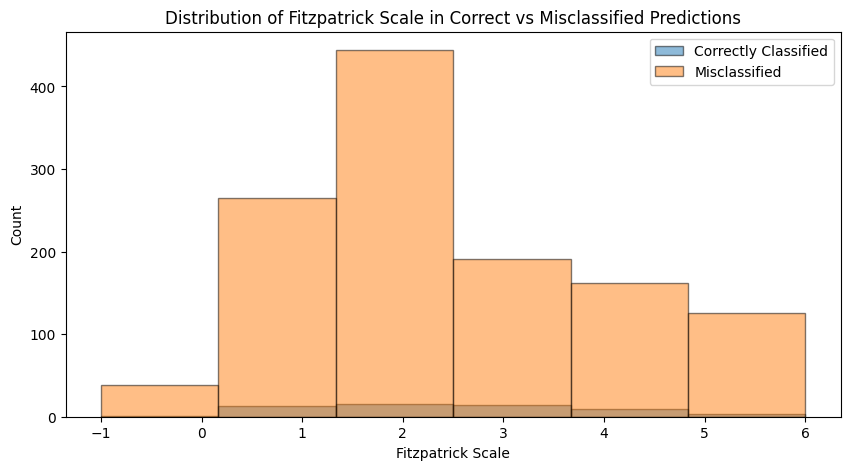

In [21]:
true_labels = val_generator.labels  # Get actual class indices
true_class_names = label_encoder.inverse_transform(true_labels)

# Get filenames in validation set
val_filenames = val_generator.filenames

# Create a DataFrame for validation results
val_results = pd.DataFrame({
    "file_path": val_filenames,
    "true_label": true_class_names,
    "predicted_label": predicted_class_names
})

# Identify misclassified and correctly classified samples
misclassified = val_results[val_results["true_label"] != val_results["predicted_label"]]
correctly_classified = val_results[val_results["true_label"] == val_results["predicted_label"]]

# Merge with train_df to get fitzpatrick scale info
misclassified = misclassified.merge(train_df[['file_path', 'fitzpatrick_scale']], on='file_path', how='left')
correctly_classified = correctly_classified.merge(train_df[['file_path', 'fitzpatrick_scale']], on='file_path', how='left')

# plot accuracy for fitzpatrick scale distribution
plt.figure(figsize=(10, 5))
plt.hist(correctly_classified["fitzpatrick_scale"], bins=6, alpha=0.5, label="Correctly Classified", edgecolor='black')
plt.hist(misclassified["fitzpatrick_scale"], bins=6, alpha=0.5, label="Misclassified", edgecolor='black')
plt.xlabel("Fitzpatrick Scale")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Fitzpatrick Scale in Correct vs Misclassified Predictions")
plt.show()


In [22]:
misclassified['true_label'].value_counts()

,count
true_label,
seborrheic-keratosis,77
acne,69
superficial-spreading-melanoma-ssm,68
eczema,68
acne-vulgaris,66
kaposi-sarcoma,64
basal-cell-carcinoma,63
mycosis-fungoides,61
squamous-cell-carcinoma,60


In [23]:
correctly_classified['true_label'].value_counts()

,count
true_label,
epidermal-nevus,6
prurigo-nodularis,5
malignant-melanoma,5
folliculitis,4
acne-vulgaris,4
acne,4
dermatofibroma,4
pyogenic-granuloma,4
keloid,3


In [24]:
# Add a column to indicate if the prediction was correct
val_results["correct"] = val_results["true_label"] == val_results["predicted_label"]

# Group by true label and compute accuracy
per_class_accuracy = val_results.groupby("true_label")["correct"].mean().sort_values(ascending=False)

# Convert to percentage
per_class_accuracy = (per_class_accuracy * 100).round(2)

# Display the results
print("Per-Class Accuracy (%):")
print(per_class_accuracy)

Per-Class Accuracy (%):
true_label
epidermal-nevus                       10.17
malignant-melanoma                     9.26
prurigo-nodularis                      9.26
folliculitis                           7.27
pyogenic-granuloma                     6.56
dermatofibroma                         6.45
keloid                                 5.77
acne-vulgaris                          5.71
acne                                   5.48
melanoma                               4.84
dyshidrotic-eczema                     3.64
basal-cell-carcinoma-morpheiform       3.39
mycosis-fungoides                      3.17
dermatomyositis                        2.22
actinic-keratosis                      1.89
seborrheic-keratosis                   1.75
squamous-cell-carcinoma                1.64
basal-cell-carcinoma                   1.56
kaposi-sarcoma                         1.54
eczema                                 0.00
superficial-spreading-melanoma-ssm     0.00
Name: correct, dtype: float64


## 6. Make Predictions on Test Data

In [25]:
test_df.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,qc,ddi_scale
0,0844ae634f0e6e7ef1f73c2aeecbae0e.jpg,2,2,NaN,12
1,3b290d262098f761d719aa07cf36c040.jpg,4,3,NaN,34
2,cf561d08ac46d0fda678bff6621005ee.jpg,2,3,NaN,12
3,e6371069be05c6b0a95b4b3f1bacc9a5.jpg,4,3,NaN,34
4,f76cddb37265f97508f159078dcc7e7c.jpg,5,5,NaN,56


In [26]:
# 6. Make Predictions on Test Data
def preprocess_test_data(test_df, directory, batch_size=32, target_size=(128, 128)):
    """
    Loads and preprocesses test images for prediction.
    """
    test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=directory,
        x_col='md5hash',  # Column that contains file names
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,  # No labels for test data
        shuffle=False  # Keep order for correct predictions
    )

    return test_generator

In [27]:
# Load test data
test_dir = folder_path + '/test/test/'
test_generator = preprocess_test_data(test_df, test_dir)

Found 1227 validated image filenames.


## 7. Generate Predictions

In [28]:
# TODO
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission
def save_predictions(test_df, test_generator, model, label_encoder, output_file="test_predictions.csv"):
    """
    Generates predictions using the trained model and saves them in the required format.
    """
    # Get predictions
    predictions = model.predict(test_generator)

    # Convert probabilities to class indices
    predicted_labels = predictions.argmax(axis=1)  # Get the index of the highest probability class

    # Convert numerical class labels back to original category names
    final_labels = label_encoder.inverse_transform(predicted_labels)

    # Remove ".jpg" from md5hash column
    test_df["md5hash"] = test_df["md5hash"].str.replace(".jpg", "", regex=False)

    # Create a DataFrame with md5hash and predicted labels
    result_df = pd.DataFrame({
        "md5hash": test_df["md5hash"],  # Ensure order is correct (shuffle=False in generator)
        "label": final_labels
    })

    # Save the results as a CSV file
    result_df.to_csv(output_file, index=False)

    print(f"Predictions saved to {output_file}")

save_predictions(test_df, test_generator, model, label_encoder)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 289s 8s/step
Predictions saved to test_predictions.csv
